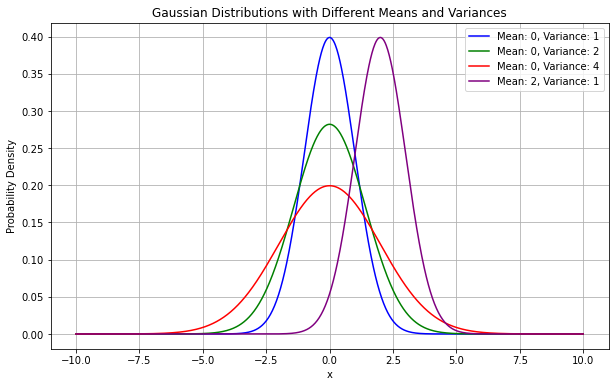

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Define the range for x
x = np.linspace(-10, 10, 1000)

# Define the parameters for different Gaussian distributions
params = [
    {"mean": 0, "variance": 1, "color": "blue"},
    {"mean": 0, "variance": 2, "color": "green"},
    {"mean": 0, "variance": 4, "color": "red"},
    {"mean": 2, "variance": 1, "color": "purple"},
]

# Plot the Gaussian distributions
plt.figure(figsize=(10, 6))
for param in params:
    mean = param["mean"]
    variance = param["variance"]
    sigma = np.sqrt(variance)
    y = (1 / (np.sqrt(2 * np.pi * variance))) * np.exp(-(x - mean) ** 2 / (2 * variance))
    plt.plot(x, y, label=f"Mean: {mean}, Variance: {variance}", color=param["color"])

plt.title("Gaussian Distributions with Different Means and Variances")
plt.xlabel("x")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()


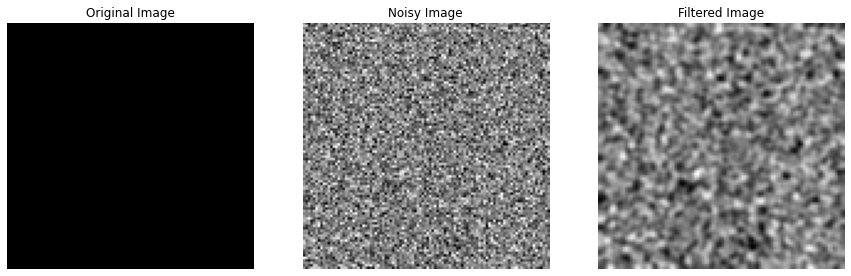

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def add_gaussian_noise(image, mean=0, sigma=25):
    noise = np.random.normal(mean, sigma, image.shape)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 255)
    return noisy_image.astype(np.uint8)

def gaussian_filter(image, kernel_size=5, sigma=1):
    return cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

# Create a sample grayscale image
image = np.ones((100, 100)) * 128  # A 100x100 image with a constant pixel value of 128

# Add Gaussian noise to the image
noisy_image = add_gaussian_noise(image, sigma=50)

# Apply Gaussian filtering to the noisy image
filtered_image = gaussian_filter(noisy_image, kernel_size=5, sigma=1)

# Plot the original, noisy, and filtered images
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Noisy Image')
plt.imshow(noisy_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Filtered Image')
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')

plt.show()


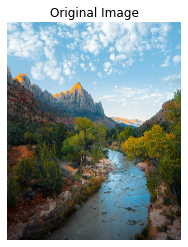

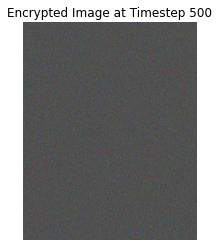

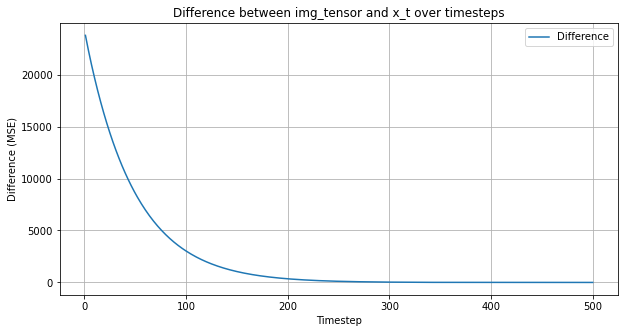

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Define parameters
beta1 = 0.01  # Example value for beta1
beta2 = 0.99  # Example value for beta2
timesteps = 1000  # Increased number of timesteps

# Construct b_t, a_t, and ab_t
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
b_t = torch.full((timesteps + 1,), 0.02, device=device)
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp().to(device)  # Move ab_t to the same device
ab_t[0] = 1.0  # Ensure the initial value is 1.0 (100% of the original image)

image_path = '../pexels-michael-block-1691617-3225517.jpg'  # Replace with your image path
img = Image.open(image_path)  
img = img.convert('RGB')  
img_array = np.array(img)
img_array = img_array / 255.0  # Normalize to [0, 1]
img_tensor = torch.tensor(img_array, dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0)  # Convert to tensor and add batch dimension, move to device

plt.imshow(np.clip(img_array, 0, 1))  # Ensure values are in [0, 1]
plt.title(f"Original Image")
plt.axis('off')
plt.show()

noise = torch.randn_like(img_tensor, device=device)
encrypted_image = ab_t.sqrt()[500, None, None, None] * img_tensor + (1 - ab_t[500, None, None, None]).sqrt() * noise

encrypted_image = encrypted_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert back to HWC format for visualization

plt.imshow(np.clip(encrypted_image, 0, 1))  # Ensure values are in [0, 1]
plt.title(f"Encrypted Image at Timestep {500}")
plt.axis('off')
plt.savefig('encrypted_image.png')  # Save the image
plt.show()

differences = []
x_t = torch.tensor(encrypted_image.copy(), dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0)

for t in range(500, -1, -1):
    x_t_minus_1 = (x_t - ((1 - a_t[t])/torch.sqrt(1-ab_t[t])) * noise) / torch.sqrt(a_t[t])
    x_t = x_t_minus_1

    decrypted_image = x_t.squeeze().permute(1, 2, 0).cpu().numpy()
    ''' plt.imshow(np.clip(decrypted_image, 0, 1))  # Ensure values are in [0, 1]
    plt.title(f"Decrypted Image at Timestep {t}")
    plt.axis('off')
    plt.show() '''

    difference = torch.mean((img_tensor - x_t) ** 2).item()  # Mean squared error
    differences.append(difference)

# Plot the differences
plt.figure(figsize=(10, 5))
plt.plot(range(500, -1, -1), differences, label='Difference')
plt.xlabel('Timestep')
plt.ylabel('Difference (MSE)')
plt.title('Difference between img_tensor and x_t over timesteps')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
for i in range(len(differences)):
        print(differences[i])

1.2829629182815552
1.2629221677780151
1.242887258529663
1.2228624820709229
1.2028523683547974
1.1828616857528687
1.1628947257995605
1.1429567337036133
1.1230525970458984
1.1031874418258667
1.0833666324615479
1.0635957717895508
1.0438803434371948
1.024226188659668
1.0046390295028687
0.9851253628730774
0.965691328048706
0.9463433623313904
0.9270881414413452
0.907932698726654
0.8888837099075317
0.8699487447738647
0.8511349558830261
0.8324500918388367
0.8139020800590515
0.7954988479614258
0.7772487998008728
0.7591602802276611
0.7412421107292175
0.7235031723976135
0.7059526443481445
0.6886000633239746
0.6714550256729126
0.6545276045799255
0.6378278136253357
0.6213662028312683
0.6051536202430725
0.5892009139060974
0.5735194087028503
0.558120846748352
0.5430169701576233
0.5282200574874878
0.5137426257133484
0.499597430229187
0.4857977032661438
0.472356915473938
0.45928892493247986
0.4466078281402588
0.4343281686306
0.4224649667739868
0.41103336215019226
0.400049090385437
0.3895281255245209
0.

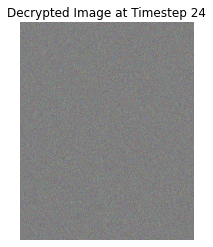

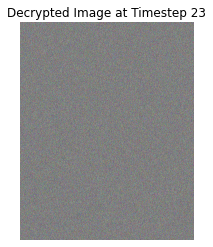

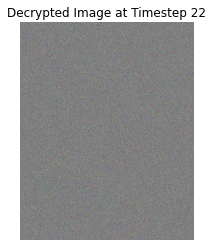

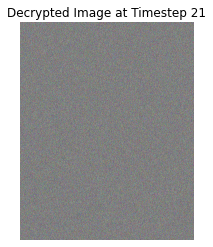

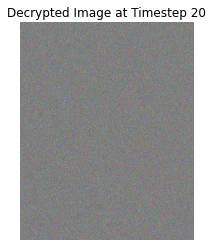

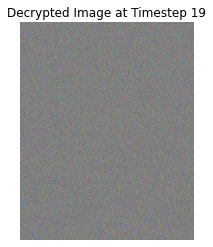

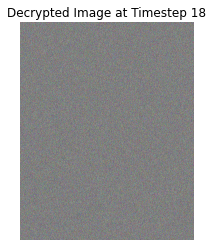

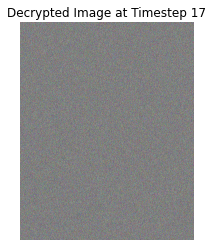

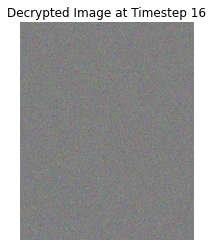

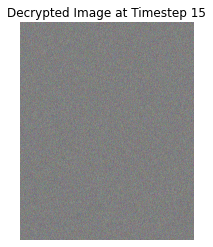

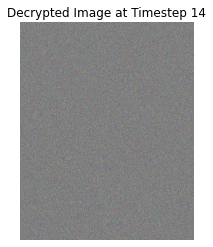

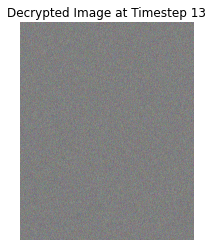

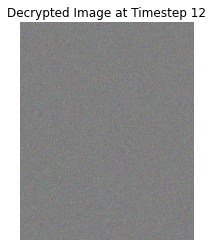

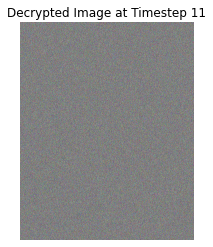

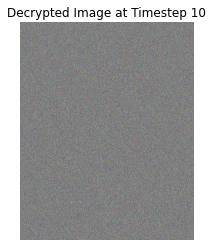

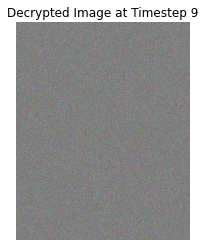

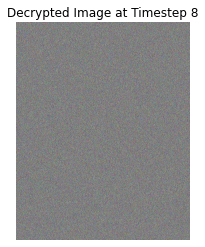

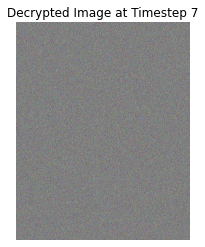

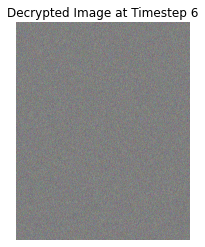

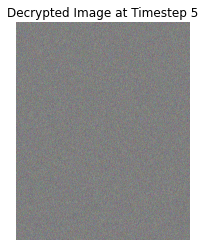

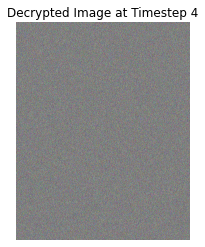

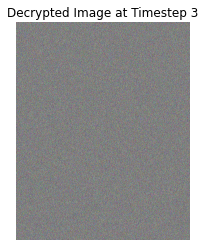

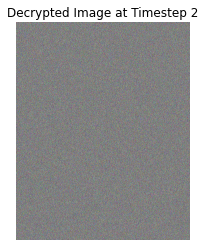

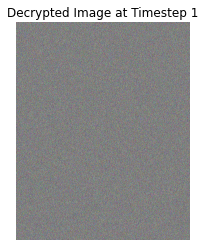

c:\Users\varun\anaconda3\lib\site-packages\matplotlib\cm.py:440: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


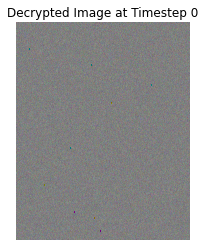

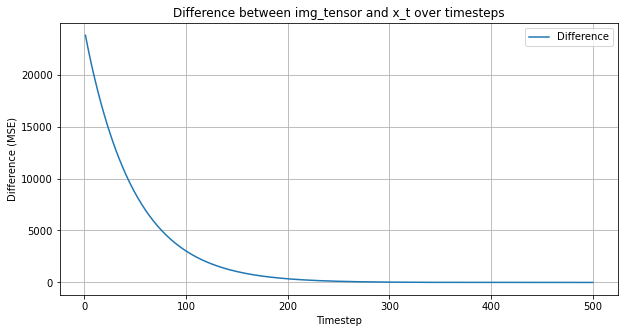

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# Define parameters
beta1 = 0.01  # Example value for beta1
beta2 = 0.99  # Example value for beta2
timesteps = 1000  # Increased number of timesteps

# Construct b_t, a_t, and ab_t
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
b_t = torch.full((timesteps + 1,), 0.02, device=device)
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp().to(device)  # Move ab_t to the same device
ab_t[0] = 1.0  # Ensure the initial value is 1.0 (100% of the original image)

image_path = '../pexels-michael-block-1691617-3225517.jpg'  # Replace with your image path
img = Image.open(image_path)  
img = img.convert('RGB')  
img_array = np.array(img)
img_array = img_array / 255.0  # Normalize to [0, 1]
img_tensor = torch.tensor(img_array, dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0)  # Convert to tensor and add batch dimension, move to device

'''plt.imshow(np.clip(img_array, 0, 1))  # Ensure values are in [0, 1]
plt.title(f"Original Image")
plt.axis('off')
plt.show() '''

noise = torch.randn_like(img_tensor, device=device)
encrypted_image = ab_t.sqrt()[500, None, None, None] * img_tensor + (1 - ab_t[500, None, None, None]).sqrt() * noise

encrypted_image = encrypted_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert back to HWC format for visualization

'''plt.imshow(np.clip(encrypted_image, 0, 1))  # Ensure values are in [0, 1]
plt.title(f"Encrypted Image at Timestep {500}")
plt.axis('off')
plt.savefig('encrypted_image.png')  # Save the image
plt.show() '''

differences = []
x_t = torch.tensor(encrypted_image.copy(), dtype=torch.float32, device=device).permute(2, 0, 1).unsqueeze(0)

for t in range(500, -1, -1):
    x_t_minus_1 = (x_t - ((1 - a_t[t])/torch.sqrt(1-ab_t[t])) * noise) / torch.sqrt(a_t[t])
    x_t = x_t_minus_1
    if(t<25):
        decrypted_image = x_t.squeeze().permute(1, 2, 0).cpu().numpy()
        plt.imshow(np.clip(decrypted_image, 0, 1))  # Ensure values are in [0, 1]
        plt.title(f"Decrypted Image at Timestep {t}")
        plt.axis('off')
        plt.show()

    difference = torch.mean((img_tensor - x_t) ** 2).item()  # Mean squared error
    differences.append(difference)

# Plot the differences
plt.figure(figsize=(10, 5))
plt.plot(range(500, -1, -1), differences, label='Difference')
plt.xlabel('Timestep')
plt.ylabel('Difference (MSE)')
plt.title('Difference between img_tensor and x_t over timesteps')
plt.legend()
plt.grid(True)
plt.show()